# Outlier Detection in Sensor Data using Functional Depth Measures

In [24]:
suppressMessages(library(MASS))
suppressMessages(library(tidyverse))
suppressMessages(library(shiny))
suppressMessages(library(shinydashboard))
suppressMessages(library(largeList))
suppressMessages(library(parallel))
suppressMessages(library(Rcpp))
suppressMessages(library(repr))
#suppressMessages(library(gganimate))

source("auxiliary/observation_vis.R")
source("auxiliary/distribution_vis.R")

options(repr.plot.width=25, repr.plot.height=6)

## Introduction
---
This project is part of a cooperation with **Daimler AG** and deals with outlier detection in sensor data from production processes. <br>
One example of data like this is the relation of angle and torque during the process of tightening a bolt in a screwing connection. This data set will be called "Endanzugsproblem" in the following notebook and contains ~350000 observations of what can be imagined as a function that maps angles to torque. The following schematic will give an idea of what the data set represents and what the problem is:

<img src="material/SchraubdatenPrinzipskizze.png">

To clarify some things about this simplified schematic:
* The so called Enganzug is only part of the tightening process, but the parts of the observation happening before it are not subject of this analysis.
* The focus of this project lies on curves that are "In Ordnung", so observations that do not immediately disqualiy themselves in some way or other by for example not reaching the fixed window of acceptable final values.
* The observations typically have a high frequency of measuring torque but the measuring points are not equidistant
* The angles where torque is measured are not shared between observations, but the measuring interval of angles might overlap between observations
* The Endanzug does not start at the same angle for every observation and also does not necessarily start at the same torque
* Outliers can be very general, so methods based on detecting only specific types of outliers may not be able to effectively filter out other suspicious observations. So optimally we would like to have some kind of Omnibus test for outliers.

Especially due to the high frequency of measurement and the non-identical points where torque is measured the idea of interpreting each observation as a function and therefore approaching the problem from a standpoint of functional data analysis comes to mind. One method that is used in functional data analysis to identify outliers is based on what is called a "functional depth measure". Gijbels and Nagy (2017) introduces the idea of depth as follows and then elaborate on the theoretical properties a depth function for functional data should possess.

> For univariate data the sample median is well known
to be appropriately describing the centre of a data
cloud. An extension of this concept for multivariate
data (say p-dimensional) is the notion of a point (in
$\mathbb{R}^p$) for which a statistical depth function is maximized. 

The idea is to define an analogous concept to centrality measures (such as the distance from some central tendency such as the median) in a scalar setting for functional data and then use those to determine which functions in a set are typical in some sense for the whole population. Due to the more applied nature of this project, I will not go into detail on the theoretical properties of the methods used, but focus on giving intuition why the chosen methods make sense in this context.

The main inspiration for my approach to the problem of detecting outliers in a data set such as the one described above is the paper "Outlier detection in functional data by depth measures, with application to identify abnormal NOx levels" by Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008). I am going to first describe their algorithm, then present my implementation and finally apply it to a simulated data set mimicking the "Endanzugsproblem" as the original data is property of Daimler AG, which I cannot make public.

## Observation Structure
---
For the sake of clarity, I will show the typical structure of one observation and define a couple of objects I will refer to later.

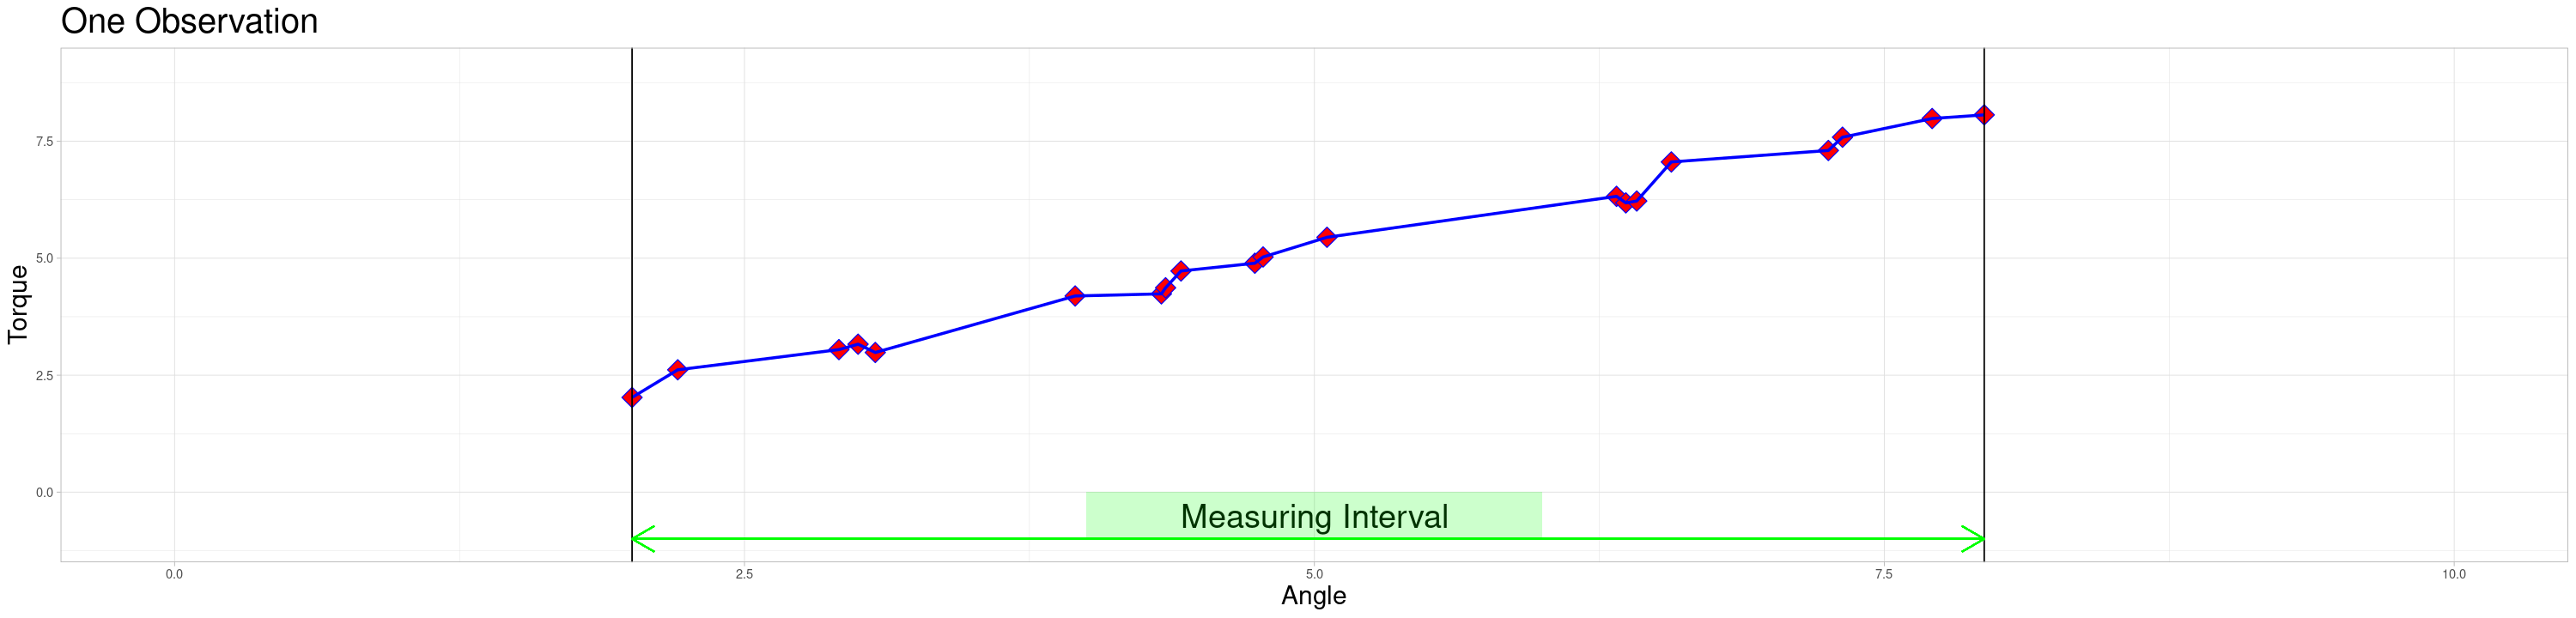

In [18]:
source("auxiliary/observation_vis.R")
obs_vis()

This shows what one observation of the data set might look like.
* The red diamonds represent measurements of torque that were taken at a recorded angle.
* The blue lines are an example of **linear interpolation** which will become important later on.
* The **measuring interval** marked in green is the convex hull of angles where measurements were taken for this observation.

The data set contains many of these objects, that do not necessairly share these characteristics.

## The Algorithm
---
The idea of Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) is an iterative process that classifies observations as outliers if their functional depth lies below a threshold C, which is determined using a bootstrapping procedure in each iteration. The algorithm can be decomposed into two parts:

1. **The iterative process**: (quoted from Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008))
    1. Obtain the functional depths $D_n(x_i), \dots ,D_n(x_n)$ for one of the functional depths [...]
    2. Let $x_{i_1}, \dots, x_{i_k}$ be the k curves such that $D_n(x_{i_k}) \leq C$, for a given cutoff C. Then, assume that $x_{i_1}, \dots, x_{i_k}$ are outliers and delete them from the sample.
    3. Then, come back to step 1 with the new dataset after deleting the outliers found in step 2. Repeat this until no more outliers are found. 
    
    <br>
2. **Determining C**: (quoted from Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008))
    1. Obtain the functional depths $D_n(x_i), \dots ,D_n(x_n)$ for one of the functional depths [...]
    2. Obtain B standard bootstrap samples of size n from the dataset of curves obtained after deleting the $\alpha \%$ less deepest curves. The bootstrap samples are denoted by $x_i^b$ for $i = 1, \dots, n$ and $b = 1, \dots, B$.
    3. Obtain smoothed bootstrap samples $y_i^b = x_i^b + z_i^b$, where $z_i^b$ is such that $(z_i^b(t_1), \dots, z_i^b(t_m))$ is normally distributed with mean 0 and covariance matrix $\gamma\Sigma_x$ where $\Sigma_x$ is the covariance matrix of $x(t_1), \dots, x(t_m)$ and $\gamma$ is a smoothing parameter. Let $y_i^b$, $i = 1, \dots,n$ and $b = 1,\dots, B$ be these samples. *
    4. For each bootstrap set $b = 1,\dots,B$, obtain $C^b$ as the empirical 1% percentile of the distribution of the depths $D(y_i^b)$, $i = 1, \dots, n$.
    5. Take C as the median of the values of $C^b$, $b = 1, \dots, B$. 
<br>
*At this point we assume that our functional observations are observed at a set of discrete points $t_1,\dots,t_m$.

To clarify some things, that might get lost in these quotes:
* n is not constant overr the iterative process, which might be counterintuitive in the context of other methods
* As a consequence: while approximating C the set of observations used is not constant over the iterative process either, as the outliers that have been removed are no longer under consideration for the bootstrap procedure

The authors propose three functional depth measures and benchmark them in a simulation setting. Because of their results and the computational cost which are comparatively small, I chose to use **h-modal depth** for my implementation, which I will introduce in the following.

## h-modal depth
---

Introduced by Cuevas, Febrero-Bande, and Fraiman (2006) h-modal depth is one of three depth measures covered in Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008). I will follow the summary in the latter paper for my overview.  <br>The idea behind this depth is that a curve is central in a set of curves if it is closely surrounded by other curves?" <br>

In mathematical terms the h-modal depth of a curve $x_i$ in relation to a set of curves $x_1, \dots, x_n$ is defined as follows: <br>
\begin{equation}
    MD_m(x_i,h) = \sum_{k = 1}^{n} K(\frac{||x_i - x_k||}{h})
\end{equation}

where $K: \mathbb{R^{+}} \rightarrow \mathbb{R^{+}}$ is a kernel function and $h$ is a bandwidth. <br>
The authors recommend using the truncated Gaussian kernel, which is defined as follows:
\begin{equation}
    K(t) = \frac{2}{\sqrt{2\pi}} \exp(-\frac{t^2}{2})
\end{equation}

and to choose $h$ as the 15th percentile of the empirical distribution of $\{||x_i - x_k|| \, ; \, i,k = 1,\dots,n\}$

I chose to implement the $L^2$ norm - one of the norms recommended by the authors - as it performed better than the $L^{\infty}$ norm (which was also recommended) in my preliminary tests. In a functional setting $L^2$ is defined by:
\begin{equation}
    ||x_i - x_k||_{2} = \sqrt{\int_a^b (x_i(t) - x_k(t))^2 dt}
\end{equation}

where a and b are the boundaries of the measurement interval. This can be replaced by its empirical version
\begin{equation}
    ||x_i - x_k||_{2} = \sqrt{\sum_{j = 1}^m (x_i(t_j) - x_k(t_j))^2 dt}
\end{equation}

in case of a discrete set of $m$ observation points shared between observations.

## Difficulties due to the Data
---
### The Endanzug does not start at the same angle for every observation. <br>
In this specific setting this is not much of a problem, as the specific angle where the "Endanzug" starts is not of importance. So all observations can be modified by subtracting the first angle of the "Endanzug" from all angles, effectively **zeroing** the observations.

<img src="material/zero.gif" width="1000" align="center">

### After zeroing, the measurement intervals might still not be identical due to differing lengths. <br>
We can define a parameter $\gamma \geq 1$ that I call **acceptable stretching** and make observations comparable by stretching their lengths by a factor $\lambda_i \in [1/\gamma, \gamma]$ before approximating them using linear interpolation. If zeroing as described in 1. is not appropriate a combination of acceptable stretching and acceptable shifting could be implemented to increase the size of sets of pairwise comparable functions.

<img src="material/stretch.gif" width="1000" align="center">

As you can already see in this animation, the acceptable stretching introduces inaccuracies even in an approximately linear setting. Outlier classifications could be quite sensitive to this parameter.

### The angles where torque is measured are not shared between observations. <br>
Assuming that the measuring intervals are identical, we can use **linear interpolation** to approximate the observations and to make them compatible with the simplification described above. This is only an approximation, but choosing an appropriately fine grid to approximate the observations should limit the influence of this procedure on the calculated functional depths.

Another possibility to approach this third problem would be to use a different version of the norm for discretized points I described above. <br>
Instead of calculating 
\begin{equation}
    ||x_i - x_k||_{2} = \sqrt{\sum_{j = 1}^m (x_i(t_j) - x_k(t_j))^2 dt}
\end{equation}

one could instead define functions $\tilde{x}_i$ which are just the piecewise linear functions defined by connecting the observed points of $x_i$. A norm based on this could be constructed as:

\begin{equation}
    ||x_i - x_k||_{\tilde{2}} = \sqrt{\int_a^b (\tilde{x}_i(t) - \tilde{x}_k(t))^2 dt}
\end{equation}

For very fine grid approximations these criteria should result in similar depths, as in practice the second approach should be proportional to the limit of the first with an increasingly fine grid. <span style="color:red"> BESSER BEGRÜNDEN</span>.

### Runtime Complexity <br>
The runtime complexity of this algorithm is at least $O(n^2)$ and I concluded that using my implementation it is infeasible use it on a very large data set such as the "Endanzugsproblem" (assuming that all observations are comparrable at once). Even when splitting up the observations as proposed above into comparable subsets, some of them will be too large to directly approach with this method. <br>
To solve this problem I instead opted to use a **sampling approach**.

In [21]:
### The gifs have been rendered using function from auxiliary/observation_vis.R (needs more packages, than are available in this environment)
# source("auxiliary/observation_vis.R")
# stretching_vis()
# zeroing_vis()

## Sampling Approach
---
Since it is infeasible to use this method on very large data sets at once, I instead made the assumption that observations that would be classified as outliers in the overall set will also be classified as outliers in subsets of the data set more frequently. So instead of performing the algorithm described above on the whole data set (or its comparable subsets), I chose to instead follow the following approach: <br>

Let $\{x_1, \dots, x_L\}$ be a set of observations that are comparable using the algorithm but too large to perform this procedure in reality.
1. Define the following objects:
    * Let *num\_samples* $ = (a_1,\dots, a_L) \in \mathbb{N_0}^L$ where $a_i$ is the number of samples $x_i$ was part of $\quad \forall i \in \{1,\dots, L\}$. <br>(Initialize all entries as 0)
    * Let *num\_outliers* $ = (b_1,\dots, b_L) \in \mathbb{N_0}^L$ where $b_i$ is the number of samples $x_i$ was classified as an outlier in $\quad \forall i \in \{1,\dots, L\}$. <br>(Initialize all as entries 0)
    * Let *frac\_outliers* $ = (c_1,\dots, c_L) \in \mathbb{R}_{\geq 0}^L$ where $c_i = \begin{cases}1 & a_i = 0 \\ \frac{b_i}{a_i} & a_i > 0\end{cases} \quad \forall i \in \{1,\dots, L\}$  <br>(Initialize all entries as 1)
2. Draw a sample of size K from $\{x_1, \dots, x_L\}$.    <span style="color:red"> MIT REPLACEMENT ODER OHNE???</span>.
3. Perform the outlier detection procedure on this sample and update the vectors accorrding to your results.
4. Go back to two and iterate this process until some condition is fulfilled.

Typical conditions could be:
* A specified number of iterations was reached
* Every observation was part of more than a specified number of samples
* The vector of certainties did not change enough according to some criterion over a specified number of iterations

In the end, the entries of *frac\_outliers* can be used as a metric for the outlyingness of an observation. If a binary decision rule is needed, every observation with an entry over some specified threshold could be classified as an outlier.

## Finding Comparable Sets of Observations
---
Assume for the sake of simplicity that **zeroing** is reasonable so that the minima of the measurement intervals of the observations are all zero. So the measurement intervals are different in their end points (or lengths which is identical in this case). As an example assume that the empirical distribution of endpoints looks as follows:

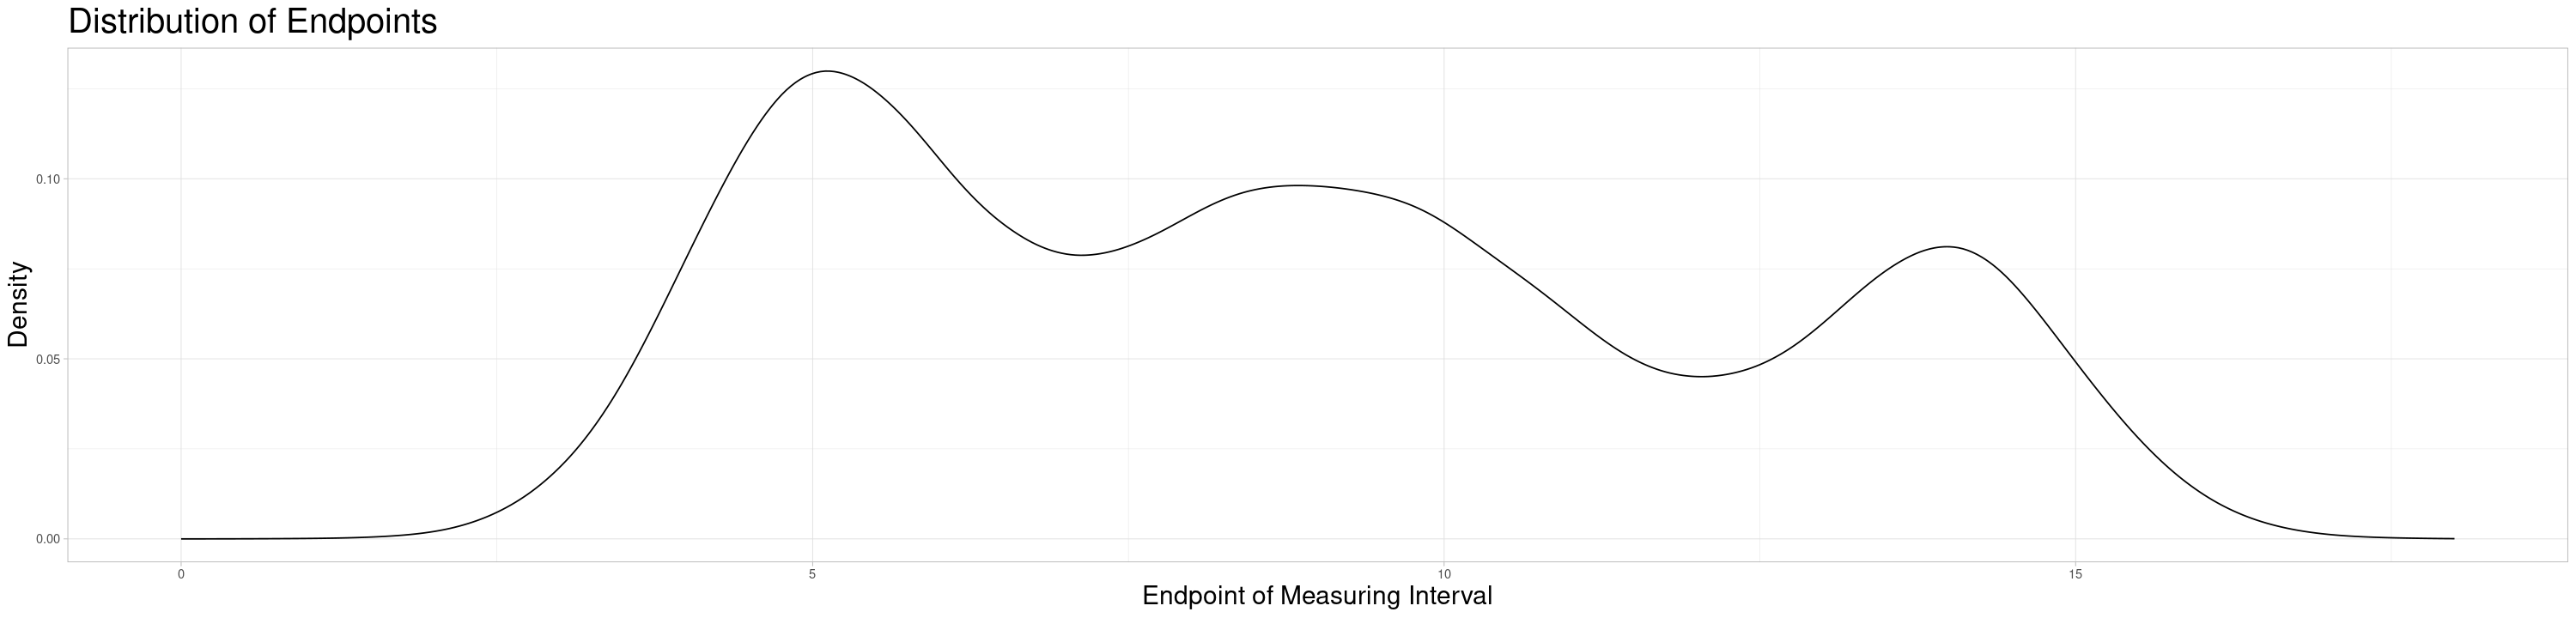

In [18]:
dist_vis()

There are three options for generating comparable subsets that came to my mind:

### Static Splitting

Partition the whole data set into pairwise disjunct subsets of pariwise comparable observations. This partition would depend of the acceptable stretching parameter. Notice that these partitions are not necessarily unique for the acceptable stretching parameter and a choice would have to be made if this approach were to be taken. <br>
Some possible partitions of the set above (not necessarily consistent with the same acceptable stretching parameter) could look like this: 

<img src="material/static_splits.gif" width="1000" align="center">

This idea has some problems:
* The choice of subsets could introduce a new source of distortions in addition to the acceptable stretching parameter.
* Adding new observations could change the chosen subsets, making an updating procedure difficult to realize.
* In each individual subset, the observations that are changed due to stretching are identical over samples. This could lead to distortions since for some observations not the original but only the stretched observations are taken into account in the classification.

### Dynamic Splitting

Allocate the comparable subsets dynamically. For each realization of the endpoint determine the subset of comparable observations and perform the sampling approach described above on this subset but keep the parameter for acceptable strertching constant for all end points. This is the variant I chose for my implementation.

<img src="material/dyn_splits.gif" width="1000" align="center">

This approach has some advantages over the first one:
* The choice of subsets becomes only a questing of the acceptable stretching and not of the choice of algorithm that chooses the partition of the data set.
* Adding new observations is unproblematic, as sampling can be done with them at the center.
* Each observation enters the classification procedure undistorted in at least the comparable subset corresponding to its own endpoint. Additionally it can enter the classification in samples, where it is comparable due to acceptable stretching. This solves the problem of observations being used for classification only in a distorted state.

### Dynamic Splitting with varying acceptable stretching parameter

As shown above, the difference in length of the measurement interval of comparable subsets changes quite substantially and does not react to the density of observations having similar measurement intervals. It would be possible to use an acceptable stretching parameter that changes locally as a function of the estimated density of end points (since zeroing was admissible in this example).
Using a simple 

<img src="material/dyn_splits2.gif" width="1000" align="center">

In this example the effect is quite subtle, but in comparison to the previous animation, one can see that the expansion of the interval of end points of comparable observations comparable is slower in regions, where the estimated density of end points is higher. This introduces another complication as the function to determine the local acceptable stretching has to be chosen, which is why I decided against this procedure as a first step.

In [77]:
### The gifs have been rendered using function from auxiliary/observation_vis.R (needs more packages, than are available in this environment)
# source("auxiliary/distribution_vis.R")
# static_splits_vis()
# dynamic_splits_vis()
# dynamic_splits2_vis()

## Updating
---
* It might be possible to modify this algorithm so that once new observations are added, the old scores only have to be updated and not calculated completely anew.
* To make these observations with similar measuring intervals tangible in this algorithm I used linear interpolation between the points at which the function was originally observed adjacent to the grid points. 
* When the measuring intervals are too dissimilar my idea was to split up the groups and instead look for outliers in group, if the observations are not outliers in another way (for example extreme measuring intervals).

## Simulated Data Set
---


## Implementation
---


In [3]:
set.seed(17203476)

In [4]:
# Parameters for the simulation:
n <- 2000
ids <- as.character(1:n)
outliers <- rbinom(n = n, size = 1, prob = 0.05)

lengths <- sample(x = 10:100, size = n, replace = TRUE)

In [5]:
# Process for drawing one realisation of functional data
random_dat <- function(grid, slope, out){
    args <- grid
    if(out == 0){
        vals <- runif(n = length(grid), min = 0, max = slope) * slope * args + rnorm(n = length(grid), mean = 0, sd = 0.05)
    }
    else{
        vals <- runif(n = length(grid), min = 0, max = 1.25 * slope) * 1.25 *slope * args + rnorm(n = length(grid), mean = 0, sd = 0.05)
    }
    
    return(list(args = grid,
                vals = vals))
}

In [6]:
functions <- map(.x = 1:n,
                 .f = function(x) random_dat(grid = seq(from = 0, to = 1, length.out = lengths[x]), slope = 1.02, out = outliers[x]))

### Allows for random access in parallelization (saves memory)
saveList(functions, "data/functions.llo") 

In [7]:
sourceCpp('auxiliary/rcpp_functions.cpp')
# gives access to grid_approx_obs & hM_depth written in C++

In [ ]:
grid_approx_single_obs <- function(func_obs, grid) {    
  return(grid_approx_obs(func_obs$args, func_obs$vals, grid))
}

grid_approx_set_obs <- function(func_dat, grid) {
  res_mat <- matrix(data = unlist(
      map(.x = func_dat,
          .f = function(obs) grid_approx_single_obs(obs, grid))
    ), nrow = length(func_dat), byrow = TRUE)
                    
  return(res_mat)
}

# func_dat needs to be observed at the same discretized points for every observation
approx_C <- function(matr_data, fdepths, alpha, B, gamma, grid) {
    
  n <- length(fdepths)
  depth_thr <- quantile(x = fdepths, probs = alpha)
  matr_data_red <- matr_data[fdepths >= depth_thr, ]
  n_red <- dim(matr_data_red)[1]
    
  Sigma_x <- cov(matr_data_red)
  my_vcov <- gamma*Sigma_x  
  grid_length <- length(grid)  

  sample_inds <- map(.x = 1:B,
                     .f = function(x) sample(x = 1:n_red, size = n, replace = TRUE))
  
  fsamples <- map(.x = sample_inds,
                  .f = function(inds) matr_data_red[inds, ])
  
  smoothing_components <- map(.x = 1:B,
                              .f = function(x) mvrnorm(n = n, mu = rep(0, times = grid_length), Sigma = my_vcov))
  
  smoothed_BS_samples <- map(.x = 1:B,
                             .f = function(b) fsamples[[b]] + smoothing_components[[b]])

  bootstrap_depths <- map(.x = 1:B,
                          .f = function(b) hM_depth(smoothed_BS_samples[[b]]))

  one_perc_quantiles <- unlist(map(.x = bootstrap_depths,
                                   .f = function(sample) quantile(sample, probs = 0.01)))
  
  return(median(one_perc_quantiles))
}

### Like this for testing purposes (plan a method later)
grid_finder <- function(func_dat){
  return(seq(0, 1, length.out = 100))
}

### function for the iterative process
outlier_iteration <- function(matr_data, alpha, B, gamma, ids, grid){
    
  fdepths <- hM_depth(matr_data)
    
  C <- approx_C(matr_data = matr_data, fdepths = fdepths, alpha = alpha,
                B = B, gamma = gamma, grid = grid)
    
  outliers <- which(fdepths < C)
  return(list(matr_data = matr_data[-outliers, ],
              outlier_ids = ids[outliers],
              outliers = outliers))
}
                                   
### function for the whole algorithm
outlier_detection <- function(func_dat, alpha, B, gamma, ids){
    
    condition <- TRUE
    outliers <- c()
    tmp_ids = ids
    i <- 1
    
    grid <- grid_finder(func_dat)
    data <- grid_approx_set_obs(func_dat, grid)
    
    while(condition){
        tmp <- outlier_iteration(matr_data = data, alpha = alpha, B = B, gamma = gamma, ids = tmp_ids, grid = grid)
        new_outliers <- tmp$outlier_ids
        if(length(new_outliers) == 0){condition <- FALSE}
        else{
          outliers <- c(outliers, new_outliers)
          data <- tmp$matr_data
          tmp_ids <- tmp$ids 
        }
    }
    
    return(outliers)
}

It is infeasible to use this algorithm on the full data set due to its runtime complexity of O(n²). So I am going to use a sampling approach, that I will describe in the following:
1. Choose a sample of size k from the overall data set (with or without replacement?) that is comparable using functional depth measures. (In the data set I generated here, each subsample is comparable due to their shared observation intervals, but this does not have to be the case.)
2. Perform the outlier detection described above on the sample and mark the suspected outliers in the sample.
3. Assume that an observation was part of $w$ samples in the overall process and was marked as an outlier in $v \leq w$ of them. For each observation report $\frac{v}{w}$ as a certainty measure that an observation is an outlier in the full data set.
4. Fix a threshold $Z \in [0,1]$ and report all observations for which $\frac{v}{w} \geq Z$ as suspected outliers.

One big advantage of this procedure is that it can be easily parallelized, making it possible to examine multiple samples at once. For the sake of simplicity I am not going to implement this parallelization in this notebook but at a later stage in a more streamlined format.

In [ ]:
if(Sys.getenv('CI') == "true"){
    num_outliers <- readRDS(file = "data/num_outliers.RDS")
    num_samples <- readRDS(file = "data/num_samples.RDS")
    certainties <- readRDS(file = "data/certainties.RDS")
} else{
total_samples <- 500
k <- 100
num_samples <- rep(x = 0, times = n)
num_outliers <- rep(x = 0, times = n)
certainties <- rep(x = 1, times = n)

sample_inds <- map(.x = 1:total_samples, 
                   .f = function(i) sample(x = 1:n, size = k, replace = FALSE))
                   
freq_samples <- tabulate(unlist(sample_inds))
num_samples[1:length(freq_samples)] <- num_samples[1:length(freq_samples)] + freq_samples    
                      
### Parallelization:

par_helper_fun <- function(list_path, index, alpha, B, gamma){
    dat <- readList(file = list_path, index = index)
    sample_flagged <- outlier_detection(func_dat = dat, alpha = 0.05, B = 50, gamma = 2, ids = index)
}
                      
num_cores <- detectCores()
cl <- makeForkCluster(num_cores)
                   
invisible(clusterCall(cl, fun = function() library('largeList')))
invisible(clusterCall(cl, fun = function() library('Rcpp')))
                   
clusterExport(cl, varlist = list("grid_approx_single_obs",
                                 "grid_approx_set_obs",
                                 "approx_C",
                                 "grid_finder",
                                 "outlier_iteration",
                                 "outlier_detection",
                                 "par_helper_fun"),
             envir = .GlobalEnv)
                      
sample_flagged_par <- clusterApplyLB(cl = cl,
                                     x = sample_inds,
                                     fun = function(smp) par_helper_fun(list_path = "data/functions.llo", 
                                                                      index = smp, alpha = 0.05, 
                                                                      B = 50, gamma = 2))

                      
stopCluster(cl)

### Only works if ids are integers (else slighty change function outlier detection to give back indices and not ids)                      
#ind_outliers <- map(.x = sample_flagged,
#                    .f = as.integer)                

#freq_outliers <- tabulate(unlist(ind_outliers))
                   
freq_outliers <- tabulate(unlist(sample_flagged_par))
num_outliers[1:length(freq_outliers)] <- num_outliers[1:length(freq_outliers)] + freq_outliers
                
certainties <- unlist(map(.x = 1:n,
                          .f = function(i) ifelse(num_samples[i] != 0, num_outliers[i]/num_samples[i], 1)))    

saveRDS(object = num_outliers, file = "data/num_outliers.RDS")                          
saveRDS(object = num_samples, file = "data/num_samples.RDS")
saveRDS(object = certainties, file = "data/certainties.RDS")
saveRDS(object = num_outliers, file = "visual/data/num_outliers.RDS")                          
saveRDS(object = num_samples, file = "visual/data/num_samples.RDS")
saveRDS(object = certainties, file = "visual/data/certainties.RDS")
}                          

Applying these to the original simulated data set yields the following results:

In [ ]:
if(Sys.getenv('CI') == "true"){
    num_outliers <- readRDS(file = "data/num_outliers.RDS")
    num_samples <- readRDS(file = "data/num_samples.RDS")
    certainties <- readRDS(file = "data/certainties.RDS")
}

print(which(num_samples == 0))                          
flagged <- which(certainties > 0.5)
original_outliers <- which(outliers == 1)
missed_outliers <- setdiff(original_outliers, flagged)
false_outliers <- setdiff(flagged, original_outliers)

saveRDS(object = list(flagged = flagged,
                      original = original_outliers,
                      missed = missed_outliers,
                      false = false_outliers),
        file = "data/outliers_info.RDS")
saveRDS(object = list(flagged = flagged,
                      original = original_outliers,
                      missed = missed_outliers,
                      false = false_outliers),
        file = "visual/data/outliers_info.RDS")

In [ ]:
# Create tibble for visualization

my_tibble <- bind_rows(map(
  .x = 1:n,
  .f = function(i) {
    tibble(
      args = functions[[i]]$args,
      vals = functions[[i]]$vals,
      id = rep(i, times = length(args)),
      cert = rep(certainties[i], times = length(args))
    )
  }
))

saveRDS(object = my_tibble, file = "data/shiny_tibble.RDS")
saveRDS(object = my_tibble, file = "visual/data/shiny_tibble.RDS")

So at least in this simple setting the algorithm identifies nearly all generated outliers and does not classify any regular point as an outlier. This is not always the case and careful choice of the tuning parameters is necessary to ensure a good performance. In the case of other data generating processes, this method can also perform worse, but is applicable in very general settings due to its functional nature.

In [ ]:
if(Sys.getenv('CI') != "true"){suppressWarnings(runApp('visual'))}

## Sources:
---
* Gijbels, I. & Nagy, S. (2017). On a General Definition of Depth for Functional Data. Statistical Science. 32. 630-639.
* Febrero-Bande, M. & Galeano, P. & Gonzàlez-Manteiga, W. (2008). Outlier detection in functional data by depth measures, with application to identify abnormal NOx levels. Environmetrics. 19. 331 - 345.
* Cuevas, A. & Febrero-Bande, M. & Fraiman, R. (2006). On the use of bootstrap for estimating functions with functional data. Computational Statistics & Data Analysis. 51. 1063-1074.